In this module, we will use AI-based approaches for planning of manufacturing process. The goal is to create a model that predicts surface roughness based on feed, cutting depth and cutting width for a milling process. The surface roughness is also influenced by other factors (like tool wear). For the sake of simplicity of this example, we will ignore these additional factors. If we want to use a model in production, we have to analyze all important factors before deploying the model.
Let's start off by visualizing the dataset.

      f        ap        ae     Rz
0  2160  0.306716  7.066666  0.704
1  2160  0.306716  7.066666  0.679
2  2160  0.306716  7.066666  0.651
3  2160  0.306893  7.116666  0.704
4  2160  0.306893  7.116666  0.670
Data set size: 280 datapoints.


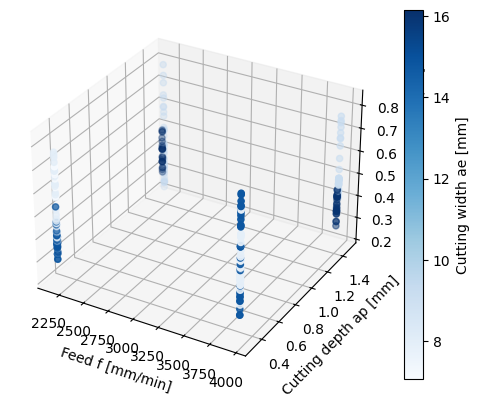

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import root_mean_squared_error


# load data
df = pd.read_excel('dataset_roughness.xlsx')
columns = ['f', 'ap', 'ae', 'Rz']
df = df[columns]

# visualize data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
graph = ax.scatter(df.f, df.ap, df.Rz, c=df.ae, cmap='Blues')
cbar = fig.colorbar(graph, ax=ax)
ax.set_xlabel('Feed f [mm/min]')
ax.set_ylabel('Cutting depth ap [mm]')
ax.set_zlabel('Surface roughness Rz [µm]')
cbar.set_label('Cutting width ae [mm]')

print(df.head())
print(f'Data set size: {len(df)} datapoints.')
plt.show()

We are working with a dataset that contains repeated measurements for the same process parameter values. In order to use the dataset, we aggregate the datapoints. We are using the mean value, so we have a reference value for surface roughness for every process parameter combination.

      f        ap         ae        Rz
0  2160  0.301601  14.866671  0.376000
1  2160  0.301628  14.866671  0.381000
2  2160  0.301702  14.850006  0.376667
3  2160  0.301729  14.900002  0.371333
4  2160  0.301740  14.866666  0.361667
Data set size: 76 datapoints.


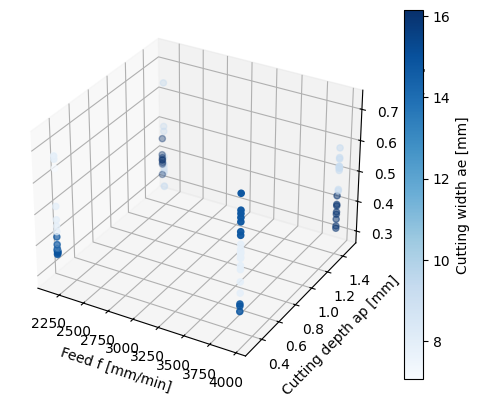

In [2]:
# aggregate data (multiple measurements)
df_agg = df.groupby(['f', 'ap', 'ae'])['Rz'].aggregate('mean').reset_index()

# visualize aggregated data
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
graph = ax.scatter(df_agg.f, df_agg.ap, df_agg.Rz, c=df_agg.ae, cmap='Blues')
cbar = fig.colorbar(graph, ax=ax)
ax.set_xlabel('Feed f [mm/min]')
ax.set_ylabel('Cutting depth ap [mm]')
ax.set_zlabel('Surface roughness Rz [µm]')
cbar.set_label('Cutting width ae [mm]')

print(df_agg.head())
print(f'Data set size: {len(df_agg)} datapoints.')
plt.show()

After aggregating the data, we split and scale the data for training.

In [3]:
# split data
training_data_ratio = 0.7
data_train = df.sample(frac=training_data_ratio, random_state=0)
data_test = df.drop(data_train.index)
train_input, train_label = data_train.drop('Rz', axis=1), data_train.Rz
test_input, test_label = data_test.drop('Rz', axis=1), data_test.Rz

# scaling
scaler = StandardScaler()
scaler.fit(train_input)
train_input = scaler.transform(train_input)
test_input = scaler.transform(test_input)

In order to train a prediction model, we first have to set up the regressor. In true AI fashion, we will use an artificial neural network. It is important to note that, especially for regression tasks, different types of models are possible (e.g. Support Vector Regression, Gaussion Process Regression, ...).
We are setting up a grid search for hyperparameter optimization. 

In [4]:
# set up regressor
neuralnet = MLPRegressor(activation='relu', solver='adam', max_iter=5000)

# cross validation for hyperparameter optimization
param_grid = {'hidden_layer_sizes': [(10,10), (25,25), (50,50), (100,100)],
              'alpha': [0.0001, 0.001, 0.01],
              'learning_rate_init': [0.001, 0.01, 0.1]}
gridsearch_cv = GridSearchCV(estimator=neuralnet, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)
gridsearch_cv.fit(train_input, train_label)

GridSearchCV(cv=5, estimator=MLPRegressor(max_iter=5000), n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01],
                         'hidden_layer_sizes': [(10, 10), (25, 25), (50, 50),
                                                (100, 100)],
                         'learning_rate_init': [0.001, 0.01, 0.1]},
             scoring='neg_root_mean_squared_error')

After training the model, we are evaluating the model RMSE and the best model parameters. Finally, we use our model to compare the training performance against the performance using a test set.

In [5]:
print(f'Best grid search RMSE: {-gridsearch_cv.best_score_}')
print(f'Best params: {gridsearch_cv.best_params_}')

# use best model from cross validation for test data prediction
best_model = gridsearch_cv.best_estimator_
test_prediction = best_model.predict(test_input)
test_rmse = root_mean_squared_error(test_label, test_prediction)

print(f'Test set RMSE: {test_rmse}')

Best grid search RMSE: 0.11207420502595869
Best params: {'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01}
Test set RMSE: 0.1749505851211296
